# Tutorial

This is a tutorial for the `momi3` package.

In [1]:
import demes, demesdraw

import momi as momi2

from momi3.MOMI import Momi

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Constructing a demographic history by demes

See [demes Tutorial](https://popsim-consortium.github.io/demes-spec-docs/main/tutorial.html#sec-tutorial) for more details on demes. Here we use a simple demog

Use [demes](https://popsim-consortium.github.io/demes-docs/main/api.html) to construct a demographic history.
The generation time `29` years per generation.

In [2]:
D = demes.Builder(generation_time=29, time_units='years')
D.add_deme("NEA", epochs=[dict(start_size=1e5, end_time=5.5e4)])
D.add_deme("GhostNea", start_time=5.51e4, epochs=[dict(end_time=4e4, start_size=1e5)], ancestors=["NEA"])
D.add_deme("YRI", start_time=5e5, epochs=[dict(start_size=1e5)], ancestors=["NEA"])
D.add_deme("CHB", start_time=8.5e4, epochs=[dict(start_size=1e4, end_time=1e4), 
                                            dict(start_size=1e4, end_size=1e5)], ancestors=["YRI"])

D.add_pulse(sources=["GhostNea"], dest="CHB", time=4.5e4, proportions=[.03])

demo = D.resolve()

Sample sizes are haploid. To get compialtion benefits of JAX use `jitted=True`.

In [3]:
momi = Momi(demo, sampled_demes=['YRI', 'CHB', 'NEA'], sample_sizes=[4, 8, 8], jitted=True)

You can simulate a chromosome and get its JSFS.

In [4]:
jsfs = momi.simulate_chromosome(
    sequence_length=1e6, recombination_rate=1.25e-8, mutation_rate=1.25e-8
)

Here are the `momi` model parameters. The left side shows the actual parameters that MOMI can learn, and the right side shows where those parameters are directed to in demes. `momi` automatically converts time from years to generations.

In [5]:
params = momi._default_params
params

Parameter,Value,Infer
┦,1e+05,❌
┧,1e+05,❌
┨,1e+05,❌
┩,1e+04,❌
┪,1e+04,❌
┫,1e+05,❌
Parameter,Value,Infer
Parameter,Value,Infer
▀,0.03,❌
Parameter,Value,Infer


One could use their favorite gradient based optimizer for momi. We recommend optax or jaxopt. Since they are optimized for JAX softwares. But feel free to use your favorite scipy function. Before optimizing first you need to set which parameters to learn. 

In [6]:
params.set_train('pi_0', True)

params.set_train('eta_2', True)
params.set_train('eta_3', True)
params.set_train('eta_4', True)
params.set_train('eta_5', True)

params.set_train('tau_1', True)
params.set_train('tau_6', True)

Here is the momi demography plotter. It uses [demesdraw](https://pypi.org/project/demesdraw/). We superimpose the parameters on that.

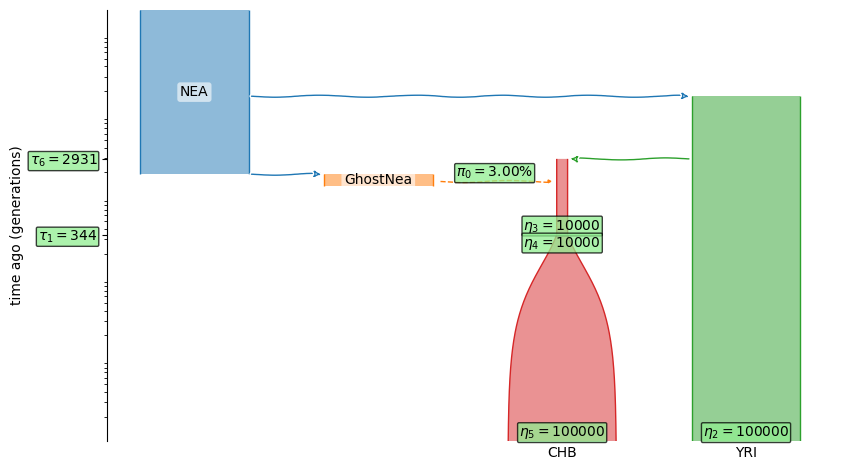

In [7]:
params.tubes(
    show_values=True,
    show_letters=True,
    log_time=True,
    hide_non_inferreds=True,
    tau_keys=['tau_1', 'tau_6']
)

We provide gradients and transformed gradients. Transformed gradients are useful for unconstrained optimization. Below function returns negative likelihood with gradients.

In [8]:
momi.negative_loglik_with_gradient(params=params, jsfs=jsfs, transformed=False)

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/math_functions.py:14: UserWarning: Explicitly requested dtype float requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x = jnp.array(x, dtype='float')


(43121.86328125,
 {'eta_2': 0.003956700209528208,
  'eta_3': 0.1301996260881424,
  'tau_1': 0.32005807757377625,
  'eta_5': 0.00022893105051480234,
  'eta_4': 0.004793066531419754,
  'tau_6': -0.4648887813091278,
  'pi_0': 3331.42333984375})

In [9]:
momi.negative_loglik_with_gradient(params=params, jsfs=jsfs, transformed=True)

(43121.8671875,
 {'softplus(eta_2)': 0.003956705331802368,
  'softplus(eta_3)': 0.1301993429660797,
  'softplus(eta_5)': 0.00022893196728546172,
  'softplus(eta_4)': 0.004793062340468168,
  'logit(pi_0)': 96.94164276123047,
  'log(tau_2-tau_1)': -3.811123860941734e-08,
  'log(tau_7-tau_6)': -722.14892578125,
  'log(tau_1-tau_0)': 110.36426544189453,
  'log(tau_6-tau_5)': -531.345458984375})

See `optimization.ipynb` for more details on optimization.